In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sympy

DIFFUSIVITY = 0.6 # Diffusivity, may want to check the vaidity of this paticular number
r_0 = 1.2 # In fm, may want to chose a better value for small nuclei
A_C = 10 # The number of nucleons in the core
TOT_ANG_MOMENTUM = 0.5 # Total angular momentum
ORB_ANG_MOMENTUM = 0 # Orbital angular momentum

BETA_1 = 0.05
BETA_2 = 0.075
BETA_3 = 0.1
BETA_4 = 0.125
BETA_5 = 0.15 # All in [fm]^-2, and are all initial guesses
BETA_INITIAL_GUESSES = [BETA_1, BETA_2, BETA_3, BETA_4, BETA_5]
INITAL_C_GUESS = 0.01
V_LS = 21.0
r, a, j, l, R0, V0, Vls = sympy.symbols('r a j l R0 V0 Vls')

We want to define the function we are fitting to as well as the functions for the gaussians

In [11]:
def five_gaussian_potential(r, c_1, beta_1, c_2, beta_2, c_3, beta_3, c_4, beta_4, c_5, beta_5, orb_ang_moment=ORB_ANG_MOMENTUM):
    """
    Defines our gaussian potential as a sum of 5 different potentials of the form V_0 e^(beta*r^2), for a set
    of beta.
    Input
    r : 1D array
    """
    V_0 = -11.39 * (-1)**orb_ang_moment - 51.13 # Defines V_0 for odd and even l states
    return - (V_0) * (c_1 * np.exp(-beta_1 * r**2) + c_2 * np.exp(-beta_2 * r**2) + c_3 * np.exp(
        -beta_3 * r**2) + c_4 * np.exp(-beta_4 * r**2) + c_5 * np.exp(-beta_5 * r**2))

def two_gaussian_potential(r, c_1, beta_1, c_2, beta_2, orb_ang_moment=ORB_ANG_MOMENTUM):
    V_0 = -11.39 * (-1)**orb_ang_moment - 51.13 # Defines V_0 for odd and even l states
    V_0 = -11.39 * (-1)**orb_ang_moment - 51.13 # Defines V_0 for odd and even l states
    return -V_0 * (c_1 * np.exp(-beta_1 * r**2) + c_2 * np.exp(-beta_2 * r**2))

We now want to use curve fit to find a set of parameters 

In [82]:
r_values = np.linspace(0, 12, 1000000)

curve_fit_result, covariances = curve_fit(
        two_gaussian_potential, r_values, woods_saxon_potential(r_values), [INITAL_C_GUESS, BETA_1, INITAL_C_GUESS, BETA_2], maxfev=10)
print(curve_fit_result)
#note: diagonal elements of the covariance matrix will give the variance on each fit parameter
errors = np.sqrt(np.diag(covariances))
print(errors)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10.

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
x_values = np.linspace(1, 12, 1000)

C_1 = 0.05
C_2 = 0.05
C_3 = 0.1
C_4 = 0.3
C_5 = 0.5

ax.set_title('Plot of potential values found')
ax.set_xlabel('radius / fm')
ax.set_ylabel('V(r)')
# ax.plot(r_values, two_gaussian_potential(r_values, curve_fit_result[0], curve_fit_result[1], curve_fit_result[2], curve_fit_result[3]), label=f'Fited gaussian Potential')
ax.plot(r_values, five_gaussian_potential(r_values, C_1, BETA_1, C_2, BETA_2, C_3, BETA_3, C_4, BETA_4, C_5, BETA_5), label=f'Guessed gaussian Potential')
ax.plot(r_values, woods_saxon_potential(r_values), label='Woods saxon potential')
ax.legend(loc='lower right')

plt.savefig('potentials_plot.png', dpi=300)
plt.show()

Since Curve_fit dosent give good results we now try a new aproach.
We start by including the spin orbit terms

In [12]:
def finding_full_woods_saxon_potential(r, a, V0, Vls, R0, j, l):
    # V_0 = -11.39 * (-1)**l - 51.13 # Defines V_0 for odd and even l states
    
    woods_saxon_function = 1 / (1 + sympy.exp(((r - R0) / a)))
    woods_saxon_derivative = sympy.diff(woods_saxon_function, r)

    woods_saxon_term = -V0 * woods_saxon_function
    l_dot_s = (( j * (j + 1)) - (l * (l + 1))- (3 / 4)) / 2
    spin_orbit_term = Vls * l_dot_s * (1 / r) * woods_saxon_derivative

    return woods_saxon_term + spin_orbit_term

print(finding_full_woods_saxon_potential(r, a, V0, Vls, R0, j, l))

-V0/(exp((-R0 + r)/a) + 1) - Vls*(j*(j + 1)/2 - l*(l + 1)/2 - 0.375)*exp((-R0 + r)/a)/(a*r*(exp((-R0 + r)/a) + 1)**2)


We now have an algerbraic expresion for our complete woods saxon potential. We now want to save this as a n expression not in sympy in order to evaluate in the curve_fit function for our gaussain parameters


In [19]:
def complete_potential(radius, tot_ang_moment=TOT_ANG_MOMENTUM, orb_ang_moment=ORB_ANG_MOMENTUM, V_ls=V_LS, diffusivity=DIFFUSIVITY, r_0=r_0, num_core_nucleons=A_C):
    V_0 = -11.39 * (-1)**orb_ang_moment - 51.13 # Defines V_0 for odd and even l states
    R_0 = r_0 * num_core_nucleons**(1/3)

    return -V_0 / (np.exp((radius - R_0) / diffusivity) + 1) - Vls * (
        tot_ang_moment * (tot_ang_moment + 1) / 2 - orb_ang_moment * (orb_ang_moment + 1
                                                                     ) / 2 - 0.375) * np.exp((
        radius - R_0) / diffusivity) / (diffusivity * radius * (np.exp((radius - R_0) / diffusivity
                                                                     ) + 1)**2)

In [20]:
r_values = np.linspace(0.0000000000000000001, 12, 1000)

curve_fit_result, covariances = curve_fit(
        two_gaussian_potential, r_values, complete_potential(r_values), [
            INITAL_C_GUESS, BETA_1, INITAL_C_GUESS, BETA_2], maxfev=100000)
print(curve_fit_result)
#note: diagonal elements of the covariance matrix will give the variance on each fit parameter
errors = np.sqrt(np.diag(covariances))
print(errors)

[ 2.94718074e+02  2.47421522e-01 -2.93747283e+02  2.48238622e-01]
[6.95825480e+04 9.62162466e-02 6.95825478e+04 9.70223398e-02]


C:\Users\faola\AppData\Local\Temp\ipykernel_12772\2090223807.py:15: RuntimeWarning: overflow encountered in exp
  return -V_0 * (c_1 * np.exp(-beta_1 * r**2) + c_2 * np.exp(-beta_2 * r**2))
C:\Users\faola\AppData\Local\Temp\ipykernel_12772\2090223807.py:15: RuntimeWarning: overflow encountered in multiply
  return -V_0 * (c_1 * np.exp(-beta_1 * r**2) + c_2 * np.exp(-beta_2 * r**2))


TypeError: loop of ufunc does not support argument 0 of type Float which has no callable log method

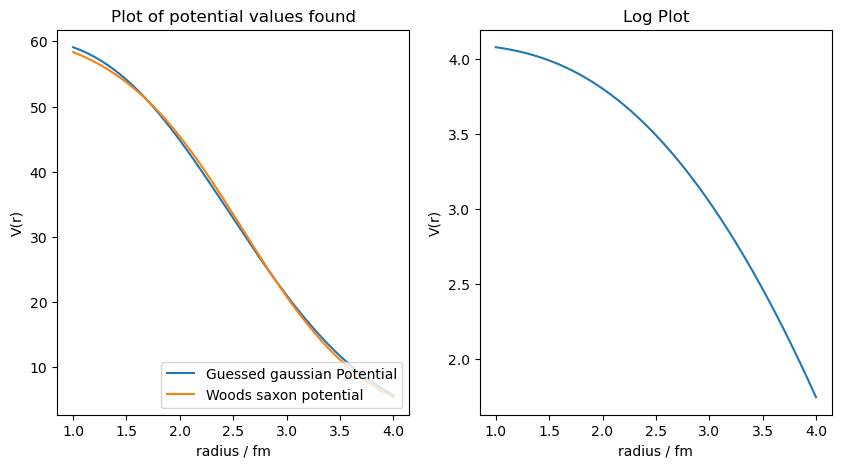

In [25]:
xvals = np.linspace(1, 4, 10000)
fig = plt.figure(figsize=(10, 5))
spec = fig.add_gridspec(ncols=2, nrows=1)
ax_1 = fig.add_subplot(spec[0, 0])
ax_2 = fig.add_subplot(spec[0, 1])

C_1, BETA_1, C_2, BETA_2 = curve_fit_result

ax_1.set_title('Plot of potential values found')
ax_1.set_xlabel('radius / fm')
ax_1.set_ylabel('V(r)')
ax_1.plot(xvals, two_gaussian_potential(xvals, C_1, BETA_1, C_2, BETA_2), label=f'Guessed gaussian Potential')
ax_1.plot(xvals, complete_potential(xvals), label='Woods saxon potential')
ax_1.legend(loc='lower right')

ax_2.set_title('Log Plot')
ax_2.set_xlabel('radius / fm')
ax_2.set_ylabel('V(r)')
ax_2.plot(xvals, np.log(two_gaussian_potential(xvals, C_1, BETA_1, C_2, BETA_2)), label=f'Guessed gaussian Potential')
ax_2.plot(xvals, np.log(complete_potential(xvals)), label='Woods saxon potential')
ax_2.legend(loc='lower right')

plt.savefig('potentials_plot.png', dpi=300)
plt.show()